# 1 构建简单的网络

In [4]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers, datasets, models

Model: "mnist_model.pngmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 784)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


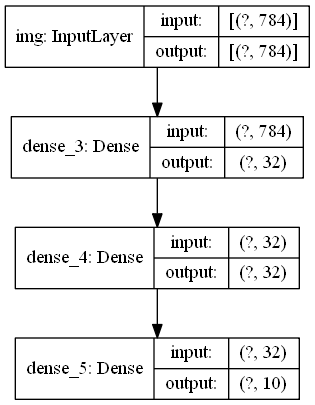

In [6]:
inputs = tf.keras.Input(shape=(784,), name='img')
h1 = layers.Dense(32, activation='relu')(inputs)
h2 = layers.Dense(32, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h2)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist_model.pngmodel')

model.summary()
# 保存相关网络信息
tf.keras.utils.plot_model(model, 'mnist_model.png')
tf.keras.utils.plot_model(model, 'model_info.png', show_shapes=True)

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') /255
x_test = x_test.reshape(10000, 784).astype('float32') /255
model.compile(optimizer=keras.optimizers.RMSprop(),
             loss='sparse_categorical_crossentropy', # 直接填api，后面会报错
             metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.2)
test_scores = model.evaluate(x_test, y_test, verbose=0)
print('test loss:', test_scores[0])
print('test acc:', test_scores[1])

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 3s 59us/sample - loss: 0.4489 - accuracy: 0.8749 - val_loss: 0.2450 - val_accuracy: 0.9281
Epoch 2/5
48000/48000 [==============================] - 2s 48us/sample - loss: 0.2209 - accuracy: 0.9362 - val_loss: 0.1888 - val_accuracy: 0.9467
Epoch 3/5
48000/48000 [==============================] - 2s 48us/sample - loss: 0.1750 - accuracy: 0.9491 - val_loss: 0.1664 - val_accuracy: 0.9501
Epoch 4/5
48000/48000 [==============================] - 1s 30us/sample - loss: 0.1472 - accuracy: 0.9571 - val_loss: 0.1497 - val_accuracy: 0.9578
Epoch 5/5
48000/48000 [==============================] - 2s 43us/sample - loss: 0.1284 - accuracy: 0.9632 - val_loss: 0.1506 - val_accuracy: 0.9586
test loss: 0.155916372191906
test acc: 0.9554


In [8]:
model.save('model_save.h5')
del model
model = keras.models.load_model('model_save.h5')

# 2 使用共享网络创建多个模型

In [9]:
# 编码器网络和自编码器网络
encode_input = keras.Input(shape=(28,28,1), name='img')
h1 = layers.Conv2D(16, 3, activation='relu')(encode_input)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.MaxPool2D(3)(h1)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.Conv2D(16, 3, activation='relu')(h1)
encode_output = layers.GlobalMaxPool2D()(h1)

encode_model = keras.Model(inputs=encode_input, outputs=encode_output, name='encoder')
encode_model.summary()

h2 = layers.Reshape((4, 4, 1))(encode_output)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
h2 = layers.Conv2DTranspose(32, 3, activation='relu')(h2)
h2 = layers.UpSampling2D(3)(h2)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
decode_output = layers.Conv2DTranspose(1, 3, activation='relu')(h2)

autoencoder = keras.Model(inputs=encode_input, outputs=decode_output, name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d (Global (None, 16)                0   

## 可以把整个模型，当作一层网络使用

In [11]:
encode_input = keras.Input(shape=(28,28,1), name='src_img')
h1 = layers.Conv2D(16, 3, activation='relu')(encode_input)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.MaxPool2D(3)(h1)
h1 = layers.Conv2D(32, 3, activation='relu')(h1)
h1 = layers.Conv2D(16, 3, activation='relu')(h1)
encode_output = layers.GlobalMaxPool2D()(h1)

encode_model = keras.Model(inputs=encode_input, outputs=encode_output, name='encoder')
encode_model.summary()

decode_input = keras.Input(shape=(16,), name='encoded_img')
h2 = layers.Reshape((4, 4, 1))(decode_input)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
h2 = layers.Conv2DTranspose(32, 3, activation='relu')(h2)
h2 = layers.UpSampling2D(3)(h2)
h2 = layers.Conv2DTranspose(16, 3, activation='relu')(h2)
decode_output = layers.Conv2DTranspose(1, 3, activation='relu')(h2)
decode_model = keras.Model(inputs=decode_input, outputs=decode_output, name='decoder')
decode_model.summary()

# 可以把整个模型，当作一层网络使用
autoencoder_input = keras.Input(shape=(28,28,1), name='img')
h3 = encode_model(autoencoder_input)
autoencoder_output = decode_model(h3)
autoencoder = keras.Model(inputs=autoencoder_input, outputs=autoencoder_output,
                          name='autoencoder')
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
src_img (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 32)          9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 16)          4624      
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 16)                0   